# Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
!which python

'which' is not recognized as an internal or external command,
operable program or batch file.


# Install dependencies:

In [5]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Ira\anaconda3\envs\csma

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       h5b45459_0         173 KB  conda-forge
    certifi-2020.12.5          |   py36ha15d459_0         143 KB  conda-forge
    llvmlite-0.35.0            |   py36haecd60e_0        15.1 MB  conda-forge
    numba-0.52.0               |   py36he38d939_0         3.6 MB  conda-forge
    openssl-1.1.1h             |       he774522_0         5.8 MB  conda-forge
    tbb-2020.1                 |       he980bc4_0         167 KB  conda-forge
    umap-learn-0.4.6           |   py36h9f0ad1d_0         111 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        25.0 MB

The following NE

# Imports

In [6]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [7]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [8]:
# Set pandas print options
This will improve readability of printed pandas dataframe.


SyntaxError: invalid syntax (<ipython-input-8-804d46c41beb>, line 2)

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [10]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [11]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [12]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [13]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.558101
n_clusters: 3 silhouette_avg: 0.3672186
n_clusters: 4 silhouette_avg: 0.30286875
n_clusters: 5 silhouette_avg: 0.33393326
n_clusters: 6 silhouette_avg: 0.29995555
n_clusters: 7 silhouette_avg: 0.28533024
n_clusters: 8 silhouette_avg: 0.319655
n_clusters: 9 silhouette_avg: 0.3314581
n_clusters: 10 silhouette_avg: 0.36581162
n_clusters: 11 silhouette_avg: 0.36710832
n_clusters: 12 silhouette_avg: 0.36825672
n_clusters: 13 silhouette_avg: 0.38552853
n_clusters: 14 silhouette_avg: 0.39271724
n_clusters: 15 silhouette_avg: 0.3909157
n_clusters: 16 silhouette_avg: 0.38463473
n_clusters: 17 silhouette_avg: 0.38840893
n_clusters: 18 silhouette_avg: 0.38651362
n_clusters: 19 silhouette_avg: 0.38506734


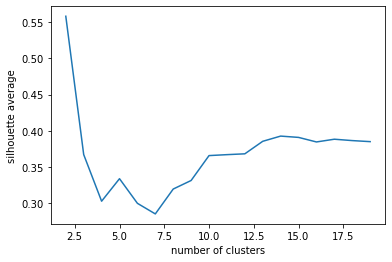

In [31]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters= 2 
max_clusters= 20 # 1000 
step= 1

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [32]:
number_of_clusters = 14 # 100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 4      52
2      57
12     59
6      64
7      66
3      68
10     73
13     82
9      93
11    118
1     120
0     122
5     125
8     132
Name: label_kmedoids, dtype: int64


In [33]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [34]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\Ira\anaconda3\envs\csma\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

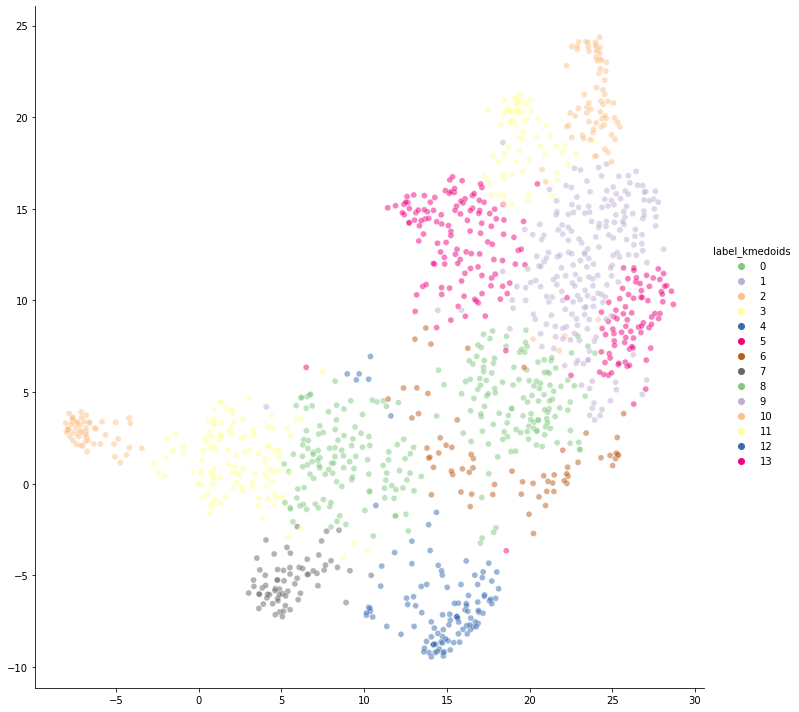

In [35]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.5 #0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

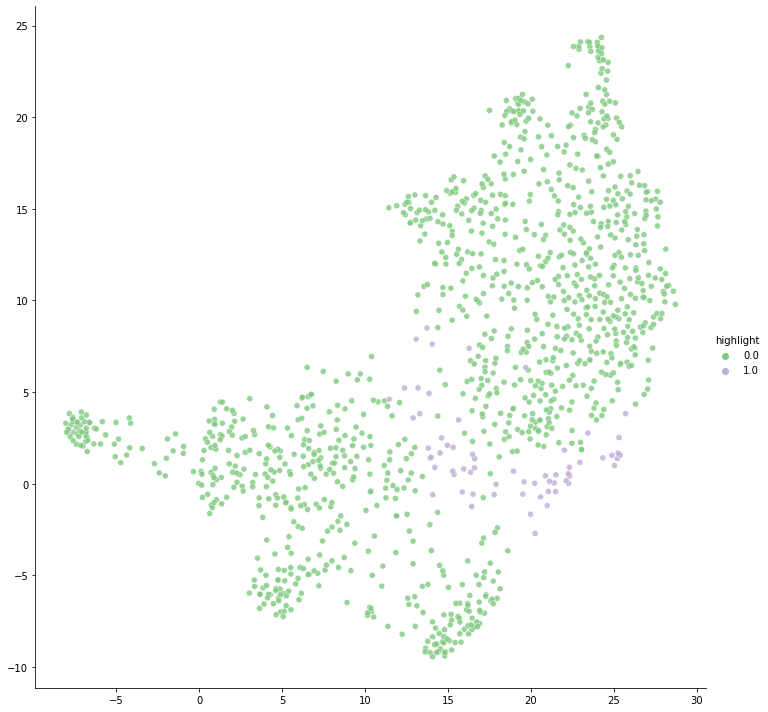

In [36]:
## Choose a cluster to higlight:
cluster_num = 6

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [37]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
589,2020-07-01 20:50:04,vikas singh,"@Isaiah correa agreed, just highlighting the largely flippant nature of the podcast",1,"@ agreed, just highlighting the largely flippant nature of the\npodcast\n\n",-1.0,0,0.000000e+00,0.0
828,2020-07-01 19:28:51,John,"When you have politicians &amp; buerocrats saying stuff like &quot;The ice caps will melt by 2020 due to climate change&quot; 20 years ago, then you wonder why people don&#39;t believe in this shit. It has turned into &quot;Vote for me or the world is going to end.&quot;",0,"When you have politicians & buerocrats saying stuff like ""The ice caps will\nmelt by 2020 due to climate change"" 20 years ago, then you wonder why people\ndon't believe in this shit. It has turned into ""Vote for me or the world is\ngoing to end.""\n\n",-1.0,1,1.192093e-07,0.0
539,2020-07-07 18:18:27,one zero,Sexy,1,Sexy\n\n,-1.0,2,0.000000e+00,0.0
1219,2020-07-01 19:11:22,Brian,"Every year we emit more than all CO2 from every volcano on earth combined, so no your comment is completely inaccurate",1,"Every year we emit more than all CO2 from every volcano on earth combined, so\nno your comment is completely inaccurate\n\n",-1.0,3,0.000000e+00,0.0
844,2020-07-01 23:46:35,Devo Davis,MC: makes logical comment Replies: ALEX JONES! Q-ANON! DEMONCRAPS IS SOCIALISM! Morons.,1,MC: makes logical comment Replies: ALEX JONES! Q-ANON! DEMONCRAPS IS\nSOCIALISM! Morons.\n\n,-1.0,4,0.000000e+00,0.0
205,2020-07-02 18:29:44,D Hern,"Are we going to ignore the fact that Covid 19 has paused industry around the world and lock down meant millions of cars were off the road, and yet co2 levels have not changed",0,"Are we going to ignore the fact that Covid 19 has paused industry around the\nworld and lock down meant millions of cars were off the road, and yet co2\nlevels have not changed\n\n",-1.0,5,5.960464e-08,0.0
761,2020-07-01 19:42:54,Nick,Exactly. Loser liberals will just ignore that though.,1,Exactly. Loser liberals will just ignore that though.\n\n,-1.0,6,0.000000e+00,1.0
353,2020-07-02 00:52:30,Rick Nof,I can&#39;t watch this. Rather I can&#39;t listen to this woman&#39;s spit swishing around in her mouth. It is sickening.,0,I can't watch this. Rather I can't listen to this woman's spit swishing around\nin her mouth. It is sickening.\n\n,-1.0,7,0.000000e+00,0.0
518,2020-07-01 21:19:23,Dylan,Yeah let me just listen to all you armchair yahoos in the comments claiming to be &quot;skeptics&quot; (we know that&#39;s not the actual case) instead of all the climate scientists who say you&#39;re all wrong,0,"Yeah let me just listen to all you armchair yahoos in the comments claiming to\nbe ""skeptics"" (we know that's not the actual case) instead of all the climate\nscientists who say you're all wrong\n\n",-1.0,8,0.000000e+00,0.0
658,2020-07-01 20:23:15,Big Shoots11,lmao this is what my dad said to. everything on the planet happens in cycles including the climate just like there were ice ages before carbon emissions although we exhale carbon. its to keep ppl in fear and looking up to politicians to think they will save us.,1,lmao this is what my dad said to. everything on the planet happens in cycles\nincluding the climate just like there were ice ages before carbon emissions\nalthough we exhale carbon. its to keep ppl in fear and looking up to\npoliticians to think they will save us.\n\n,-1.0,9,1.192093e-07,0.0


In [38]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  122 mean distance from center:  0.006765078433090821 Proportion of replies: 82.78688524590164
1 number of samples:  120 mean distance from center:  0.0067150591348763555 Proportion of replies: 40.833333333333336
2 number of samples:  57 mean distance from center:  0.001332529791397974 Proportion of replies: 66.66666666666667
3 number of samples:  68 mean distance from center:  0.004154882117290981 Proportion of replies: 61.76470588235294
4 number of samples:  52 mean distance from center:  0.005724453149014153 Proportion of replies: 51.92307692307692
5 number of samples:  125 mean distance from center:  0.006795597437303513 Proportion of replies: 76.8
6 number of samples:  64 mean distance from center:  0.008032936602830887 Proportion of replies: 81.25
7 number of samples:  66 mean distance from center:  0.0036798643122892827 Proportion of replies: 34.84848484848485
8 number of samples:  132 mean distance from center:  0.007546896085841581 Proportion of replies: 6

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [55]:
# Choose a cluster to print
cluster_number = 6
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 64
Average Distance from cluster center: 8.0329366e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
761,2020-07-01 19:42:54,Nick,Exactly. Loser liberals will just ignore that though.,1,Exactly. Loser liberals will just ignore that though.\n\n,-1,6,0.000000,1.0
300,2020-07-05 16:41:59,silviu visan,@ledernierutopiste right wingers are ignorant who would have thought,1,@ right wingers are ignorant who would have thought\n\n,-1,6,0.000002,1.0
69,2020-07-21 06:47:36,B4DGER,How many right wing people are watching this video?,0,How many right wing people are watching this video?\n\n,-1,6,0.000005,1.0
165,2020-07-08 22:01:28,Mike Byrne,@Richie Anthony republicans are retards. Oopsies.,1,@ republicans are retards. Oopsies.\n\n,-1,6,0.000005,1.0
787,2020-07-01 21:32:09,night mark,lol first Conservatives denies it and now ideas for solutions is garbage.,1,lol first Conservatives denies it and now ideas for solutions is garbage.\n\n,-1,6,0.000006,1.0
627,2020-07-01 20:10:31,Spliff Sensei Roe Jogan,What makes no sense to me is like how the pro right ppl don’t see the job creation in embracing “pollution”,0,What makes no sense to me is like how the pro right ppl don’t see the job\ncreation in embracing “pollution”\n\n,-1,6,0.000006,1.0
930,2020-07-01 19:21:44,Angeline,"@Andrea they didn't say anything about the right, you projected that.",1,"@ they didn't say anything about the right, you projected that.\n\n",-1,6,0.000006,1.0
740,2020-07-01 21:22:58,Michael Gleason,The left is acting like it isn't real.,1,The left is acting like it isn't real.\n\n,-1,6,0.000012,1.0
931,2020-07-01 19:20:36,Andrea,"But the right is pure and tells the truth? Okay. If you believe that, you're still just as brainwashed as you were when you were on the left.",1,"But the right is pure and tells the truth? Okay. If you believe that, you're\nstill just as brainwashed as you were when you were on the left.\n\n",-1,6,0.000015,1.0
302,2020-07-04 08:44:43,Opaque Rayne,"@ledernierutopiste To say just one side is ""sensitive"" is utter nonsense. BOTH sides trigger on this and to not admit or say that is disingenuous to say the least.",1,"@ To say just one side is ""sensitive"" is utter nonsense. BOTH\nsides trigger on this and to not admit or say that is disingenuous to say the\nleast.\n\n",-1,6,0.000016,1.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [56]:
#which cluster would you like to assign labels to?
cluster_number = 6
#your label
label_manual = 'left_right_dispute'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [57]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
761,2020-07-01 19:42:54,Nick,Exactly. Loser liberals will just ignore that though.,1,Exactly. Loser liberals will just ignore that though.\n\n,left_right_dispute,6,0.000000,1.0
300,2020-07-05 16:41:59,silviu visan,@ledernierutopiste right wingers are ignorant who would have thought,1,@ right wingers are ignorant who would have thought\n\n,left_right_dispute,6,0.000002,1.0
69,2020-07-21 06:47:36,B4DGER,How many right wing people are watching this video?,0,How many right wing people are watching this video?\n\n,left_right_dispute,6,0.000005,1.0
165,2020-07-08 22:01:28,Mike Byrne,@Richie Anthony republicans are retards. Oopsies.,1,@ republicans are retards. Oopsies.\n\n,left_right_dispute,6,0.000005,1.0
787,2020-07-01 21:32:09,night mark,lol first Conservatives denies it and now ideas for solutions is garbage.,1,lol first Conservatives denies it and now ideas for solutions is garbage.\n\n,left_right_dispute,6,0.000006,1.0
627,2020-07-01 20:10:31,Spliff Sensei Roe Jogan,What makes no sense to me is like how the pro right ppl don’t see the job creation in embracing “pollution”,0,What makes no sense to me is like how the pro right ppl don’t see the job\ncreation in embracing “pollution”\n\n,left_right_dispute,6,0.000006,1.0
930,2020-07-01 19:21:44,Angeline,"@Andrea they didn't say anything about the right, you projected that.",1,"@ they didn't say anything about the right, you projected that.\n\n",left_right_dispute,6,0.000006,1.0
740,2020-07-01 21:22:58,Michael Gleason,The left is acting like it isn't real.,1,The left is acting like it isn't real.\n\n,left_right_dispute,6,0.000012,1.0
931,2020-07-01 19:20:36,Andrea,"But the right is pure and tells the truth? Okay. If you believe that, you're still just as brainwashed as you were when you were on the left.",1,"But the right is pure and tells the truth? Okay. If you believe that, you're\nstill just as brainwashed as you were when you were on the left.\n\n",left_right_dispute,6,0.000015,1.0
302,2020-07-04 08:44:43,Opaque Rayne,"@ledernierutopiste To say just one side is ""sensitive"" is utter nonsense. BOTH sides trigger on this and to not admit or say that is disingenuous to say the least.",1,"@ To say just one side is ""sensitive"" is utter nonsense. BOTH\nsides trigger on this and to not admit or say that is disingenuous to say the\nleast.\n\n",left_right_dispute,6,0.000016,1.0


In [53]:
#which cluster would you like to assign labels to?
cluster_number = 8
#your label
label_manual = 'scientific_community'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [54]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
518,2020-07-01 21:19:23,Dylan,Yeah let me just listen to all you armchair yahoos in the comments claiming to be &quot;skeptics&quot; (we know that&#39;s not the actual case) instead of all the climate scientists who say you&#39;re all wrong,0,"Yeah let me just listen to all you armchair yahoos in the comments claiming to\nbe ""skeptics"" (we know that's not the actual case) instead of all the climate\nscientists who say you're all wrong\n\n",scientific_community,8,0.000000,0.0
1035,2020-07-01 19:54:35,McHitler,"When you deny the demonstrable predictive power of several fields of science people are rightly going to call you a ""denier"" of some stripe. At least own up to it.",1,"When you deny the demonstrable predictive power of several fields of science\npeople are rightly going to call you a ""denier"" of some stripe. At least own\nup to it.\n\n",scientific_community,8,0.000009,0.0
744,2020-07-01 19:46:17,Demarcus Black,"The same idiots that won&#39;t shut up about science they don&#39;t understand are the same idiots who say biology is a social construct. AFAIC, this was settled by Randall Carlson in episode 606.",0,"The same idiots that won't shut up about science they don't understand are the\nsame idiots who say biology is a social construct. AFAIC, this was settled by\nRandall Carlson in episode 606.\n\n",scientific_community,8,0.000013,0.0
653,2020-07-01 20:23:42,Alhaji Bah,Coming from an economist and a scientist lmao,1,Coming from an economist and a scientist lmao\n\n,scientific_community,8,0.000015,0.0
47,2020-09-13 16:25:02,Bob D,"@Bestoink Dooley So I am right. You never bothered to study the basic science? You don't know the basic science science! And you don't understand how science can be corrupted. So you don't even have an opinion. You just parrot the status quo dogma. All you can do is get emotional and laugh at someone who has taken the issue seriously. Listened to both sides carefully. And formed my own opinion. Good luck with that approach to knowledge. /life. So not only are you ignorant of the basic science, you also have a big mouth brodcasting your ignorance. That makes you an ignorant loudmouth. As I said. Good luck with that.",1,"@Bestoink Dooley So I am right. You never bothered to study the basic science?\nYou don't know the basic science science! And you don't understand how science\ncan be corrupted. So you don't even have an opinion. You just parrot the\nstatus quo dogma. All you can do is get emotional and laugh at someone who has\ntaken the issue seriously. Listened to both sides carefully. And formed my own\nopinion. Good luck with that approach to knowledge. /life. So not only are you\nignorant of the basic science, you also have a big mouth brodcasting your\nignorance. That makes you an ignorant loudmouth. As I said. Good luck with\nthat.\n\n",scientific_community,8,0.000015,0.0
1031,2020-07-01 20:02:18,Dillon Arnold,"The problem is people who deny it don’t actually do research. They read brief articles they specifically seek to fit their confirmation bias and somehow figure they know better than Nobel prize winning teams of scientists and researchers at the most revered institutions in the world. They don’t read actual scientific papers, they don’t look at data, they don’t debunk research. Its people with basically absolutely no knowledge or education on the subject Judging the competency of those who do. It’s the same with people having an opinion on any complicated manner they really have no fucking idea about.",1,"The problem is people who deny it don’t actually do research. They read brief\narticles they specifically seek to fit their confirmation bias and somehow\nfigure they know better than Nobel prize winning teams of scientists and\nresearchers at the most revered institutions in the world. They don’t read\nactual scientific papers, they don’t look at data, they don’t debunk resear

In [42]:
#which cluster would you like to assign labels to?
cluster_number = 4 # also 12
#your label
label_manual = 'attitude_towards_rogan'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [43]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
844,2020-07-01 23:46:35,Devo Davis,MC: makes logical comment Replies: ALEX JONES! Q-ANON! DEMONCRAPS IS SOCIALISM! Morons.,1,MC: makes logical comment Replies: ALEX JONES! Q-ANON! DEMONCRAPS IS\nSOCIALISM! Morons.\n\n,attitude_towards_rogan,4,0.000000,0.0
974,2020-07-01 19:14:42,Damian Dennis,"Get two sides to discuss this topic... this is pointless, I would appreciate dialogue from both sides instead of name calling or Joe conveniently forgetting points of rebuttal that he has already heard from esteemed guests on his podcasts.",0,"Get two sides to discuss this topic... this is pointless, I would appreciate\ndialogue from both sides instead of name calling or Joe conveniently\nforgetting points of rebuttal that he has already heard from esteemed guests\non his podcasts.\n\n",attitude_towards_rogan,4,0.000004,0.0
630,2020-07-01 20:06:20,King Gordon,"<a href=""https://www.technologyreview.com/2019/11/25/131832/russia-disinformation-twitter-internet-research-agency-social-media-politics/"">https://www.technologyreview.com/2019/11/25/131832/russia-disinformation-twitter-internet-research-agency-social-media-politics/</a><br />The Russian Troll farms are actually terrible at changing people&#39;s minds. I wish Joe would stop bringing them up like they have this mystical power.",0,\ntwitter-internet-research-agency-social-media-politics/ \nThe Russian Troll farms are actually terrible at changing people's minds. I\nwish Joe would stop bringing them up like they have this mystical power.\n\n,attitude_towards_rogan,4,0.000009,0.0
330,2020-07-03 02:26:54,SJ D,If he knows nothing should be easy for Joe to expose him... and make for great podcasting... but your right Tony Heller is a Boss.,1,If he knows nothing should be easy for Joe to expose him... and make for great\npodcasting... but your right Tony Heller is a Boss.\n\n,attitude_towards_rogan,4,0.000010,0.0
429,2020-07-01 23:00:23,Patrick L,"Why do Joe's conservative listeners continue to delude themselves into thinking he's right wing when he's supported Bernie and Tulsi, he's from Massachusetts which has always been a blue state, and has repeatedly said he's left leaning?",1,"Why do Joe's conservative listeners continue to delude themselves into\nthinking he's right wing when he's supported Bernie and Tulsi, he's from\nMassachusetts which has always been a blue state, and has repeatedly said he's\nleft leaning?\n\n",attitude_towards_rogan,4,0.000010,0.0
426,2020-07-01 22:05:47,Ken C,Why does Joe act Democrat when deep down he knows what&#39;s up.,0,Why does Joe act Democrat when deep down he knows what's up.\n\n,attitude_towards_rogan,4,0.000011,0.0
227,2020-07-02 14:15:59,mrlukenukem88,"Joe should have 2 science experts on each side of the debate answer some questions like what percent of climate change is from humans/ what are other factors, if humans is 1-10 percent that would change a lot of perspectives if it’s 80 percent and up would change a lot of perspectives",0,"Joe should have 2 science experts on each side of the debate answer some\nquestions like what percent of climate change is from humans/ what are other\nfactors, if humans is 1-10 percent that would change a lot of perspectives if\nit’s 80 percent and up would change a lot of perspectives\n\n",attitude_towards_rogan,4,0.000012,0.0
872,2020-07-01 19:23:22,guymon82ify,Joe is team climate change no matter what! Lol they are projecting what other people think but totally doing the same thing! Lol,0,Joe is team climate change no matter what! Lol they are projecting what other\npeople think but totally doing the same thing! Lol\n\n,attitude_towards_rogan,4,0.000013,0.0
941,2020-07-01 19:17:51,Mike Mc,"Yeah Joe, believe it or not, but not all of us have a 100 million dollar contract to talk... so excuse me if I have to work while you protest the temperature.",0,"Yeah Joe, believe it or not, but not all of us have a 100 m

In [45]:
#which cluster would you like to assign labels to?
cluster_number = 2
#your label
label_manual = 'nonsense'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [46]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
539,2020-07-07 18:18:27,one zero,Sexy,1,Sexy\n\n,nonsense,2,0.000000e+00,0.0
512,2020-07-03 01:11:57,Daniel Cuckler,@Media Buster what?,1,@ what?\n\n,nonsense,2,4.768372e-07,0.0
1227,2020-07-01 19:01:19,Kuan,uff,0,uff\n\n,nonsense,2,8.344650e-07,0.0
1133,2020-07-01 19:06:18,bm2g,"<a href=""http://www.youtube.com/results?search_query=%23pizzagate"">#pizzagate</a>",0,#pizzagate\n\n,nonsense,2,1.430511e-06,0.0
994,2020-07-01 19:41:59,James alt,Bahahahahwhwahahahahaha,1,Bahahahahwhwahahahahaha\n\n,nonsense,2,2.443790e-06,0.0
1068,2020-07-01 19:13:21,Individual Thought Patterns,WHUT?,1,WHUT?\n\n,nonsense,2,2.503395e-06,0.0
525,2020-07-01 21:17:33,Nick Martyn,HIllary,0,HIllary\n\n,nonsense,2,2.563000e-06,0.0
270,2020-07-07 18:19:05,one zero,😂,1,😂\n\n,nonsense,2,2.622604e-06,0.0
182,2020-08-01 10:59:05,Ry Rosa,@Væringjar 😉,1,@ 😉\n\n,nonsense,2,2.622604e-06,0.0
1177,2020-07-01 19:03:15,ZERAHIAH SEGOVIA,Ufjo,0,Ufjo\n\n,nonsense,2,2.682209e-06,0.0


In [50]:
#which cluster would you like to assign labels to?
cluster_number = 7
#your label
label_manual = 'attitude_towards_freese '
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [51]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
353,2020-07-02 00:52:30,Rick Nof,I can&#39;t watch this. Rather I can&#39;t listen to this woman&#39;s spit swishing around in her mouth. It is sickening.,0,I can't watch this. Rather I can't listen to this woman's spit swishing around\nin her mouth. It is sickening.\n\n,attitude_towards_freese,7,0.000000,0.0
535,2020-07-01 21:03:46,asundaydrrive,This woman’s voice makes me want to club baby seals.,0,This woman’s voice makes me want to club baby seals.\n\n,attitude_towards_freese,7,0.000002,0.0
334,2020-07-02 01:56:29,Josh Melton,I had to stop listening because of the amount of liquid moving around in her mouth while she was speaking.,0,I had to stop listening because of the amount of liquid moving around in her\nmouth while she was speaking.\n\n,attitude_towards_freese,7,0.000005,0.0
554,2020-07-02 01:59:03,Scientists Baffled,Growlers eww her old lady lips just flopping about all willy-nilly. You can hear the tapioca and quinoa just smacking off her dentures. Lost my appetite can't even watch the video thank you.I hate it,1,Growlers eww her old lady lips just flopping about all willy-nilly. You can\nhear the tapioca and quinoa just smacking off her dentures. Lost my appetite\ncan't even watch the video thank you.I hate it\n\n,attitude_towards_freese,7,0.000005,0.0
286,2020-07-02 05:02:42,Hold on I’m talking brotha,"Idk why but I’d simp for this lady, something about her is so calm",0,"Idk why but I’d simp for this lady, something about her is so calm\n\n",attitude_towards_freese,7,0.000005,0.0
571,2020-07-01 20:42:06,Carlos Ramirez,"I tried hard to concentrate, but it sounded like she had a leaky ceiling in her mouth🤔",0,"I tried hard to concentrate, but it sounded like she had a leaky ceiling in\nher mouth🤔\n\n",attitude_towards_freese,7,0.000005,0.0
487,2020-07-01 21:27:11,Vladimir Putin,I love how whenever a woman on this show talks about something that everyone agrees with all of a sudden the dislike ratio is insane,0,I love how whenever a woman on this show talks about something that everyone\nagrees with all of a sudden the dislike ratio is insane\n\n,attitude_towards_freese,7,0.000006,0.0
719,2020-07-01 19:48:22,DATMAN,"Honestly her ideas didn’t bother me, it was just the sound her mouth made when she talked. Like she needs a sip of water I can hear little smacks lol",0,"Honestly her ideas didn’t bother me, it was just the sound her mouth made when\nshe talked. Like she needs a sip of water I can hear little smacks lol\n\n",attitude_towards_freese,7,0.000006,0.0
530,2020-07-01 21:10:08,Linus Abrahamsson,can she stop smacking annoying af,0,can she stop smacking annoying af\n\n,attitude_towards_freese,7,0.000007,0.0
798,2020-07-01 19:34:20,Garrett Link,"This lady is the most dangerous kind of arrogance, she is articulate, and passive aggressively arrogant.",0,"This lady is the most dangerous kind of arrogance, she is articulate, and\npassive aggressively arrogant.\n\n",attitude_towards_freese,7,0.000009,0.0
